In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

import os
from tqdm import tqdm
import json

Using TensorFlow backend.


In [10]:
def VGG_11(input_shape, classes):
    activation_f = 'relu'
    momemtum = 0.8
    input_img = Input(shape=input_shape)
    # Block 1
    # layer 1
    x = Conv2D(32, (3,3), strides=1, activation='linear', padding='same')(input_img)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    # Block 2
    #layer 2
    x = Conv2D(64, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    # Block 3
    #layer 3
    x = Conv2D(128, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
     #layer 4
    x = Conv2D(128, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    # Block 4
    #layer 5
    x = Conv2D(256, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
     #layer 6
    x = Conv2D(256, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    # Block 5
    # layer 7
    x = Conv2D(256, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
     #layer 8
    x = Conv2D(256, (3,3), strides=1, activation='linear', padding='same')(x)
    x = BatchNormalization(momentum=momemtum)(x)
    x = Activation(activation_f)(x)
    x = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    
    #layer 9
    #fully-connected layer
    x = Flatten()(x)
    
     #layer 10
    x = Dense(512, activation='linear')(x)
    x = Activation(activation_f)(x)
     #layer 11
    x = Dense(512, activation='linear')(x) 
    x = Activation(activation_f)(x)
    x = Dropout(0.2)(x)
    
    # softmax layer (output)
    pred = Dense(classes, activation='softmax')(x)
    
    model  = Model(input_img , pred)
    
    return model
    

In [3]:
def graph_training_history(history):
    acc_train = history['accuracy']
    acc_test = history['val_accuracy']
    loss_train = history['loss']
    loss_test = history['val_loss']
    #print(acc_train, acc_test, loss_train, loss_test)
    plt.rcParams['axes.facecolor']='white'
    plt.figure(1)

    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(acc_train)
    plt.plot(acc_test)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()

    # summarize history for loss
    plt.subplot(122)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    
    plt.show()

In [4]:
# Augmentations
train_aug=ImageDataGenerator(rescale=1./255,
                    height_shift_range=0.2, featurewise_center=0,
                    horizontal_flip=True, vertical_flip=True,
                    zoom_range=0.3)

# No Augmentations
#train_aug = ImageDataGenerator(rescale=1./255)

#Paths dos datasets
train_folder = "UCMERCED_HW_SceneClassification/data/separated_in_labels_aug/train"
val_folder = "UCMERCED_HW_SceneClassification/data/separated_in_labels_aug/val"

# train_folder = "UCMERCED_HW_SceneClassification/data/separated_in_labels/train"
# val_folder = "UCMERCED_HW_SceneClassification/data/separated_in_labels/val"

In [14]:
# Definina o batch-size e tamanho da imagem de entrada
batch_size = 32
input_shape = (256, 256, 3)
(w, h, _) = input_shape
print(w,h)
train_generator = train_aug.flow_from_directory(train_folder, 
                                           target_size=(w, h),batch_size=batch_size, 
                                           class_mode='categorical', shuffle=True, seed=42)

val_generator = train_aug.flow_from_directory(val_folder,  
                                         target_size=(w, h),  batch_size=batch_size,  
                                         class_mode='categorical', shuffle=True, seed=42)

256 256
Found 5367 images belonging to 21 classes.
Found 1353 images belonging to 21 classes.


In [16]:
# Pega o tamanho total de imagens no dataset
filenames = train_generator.filenames
samples = len(filenames)
print(samples)

5367


In [17]:
# Define o Early Stopping e salva o melhor modelo durante o treino
file_name = 'best_model.h5'
checkpointer = ModelCheckpoint(file_name, monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001,
mode = 'max', patience = 10)
callbacks=[checkpointer,early_stop]

In [18]:
# Define o número de classes, número de épocas e o learning rate e o decaimento usado
classes = 21
epochs = 100
steps_in_epoch = samples // batch_size
lr = 1e-3
adam = Adam(learning_rate = lr, decay=0.01)
net = VGG_11(input_shape, classes)
net.compile(loss = 'categorical_crossentropy', optimizer=adam , metrics=['accuracy'])
net.summary()

history = net.fit_generator(train_generator, steps_per_epoch=steps_in_epoch, epochs=epochs, 
                              validation_data=val_generator,  validation_steps=1, 
                              verbose=1,callbacks=callbacks)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_31 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 128, 64)      256 

KeyboardInterrupt: 

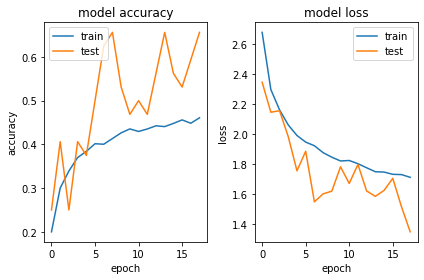

In [19]:
# Mostra o gráfico ao fim do treino
graph_training_history(history.history)

In [20]:
# Salva o modelo ao final do treino (não o melhor) e salva a história do treinamento em formato de string
net.save('weights/model_END.h5')
# Saving history
with open('weights/history_model.json', 'w') as f:
    json.dump(str(net.history.history), f)

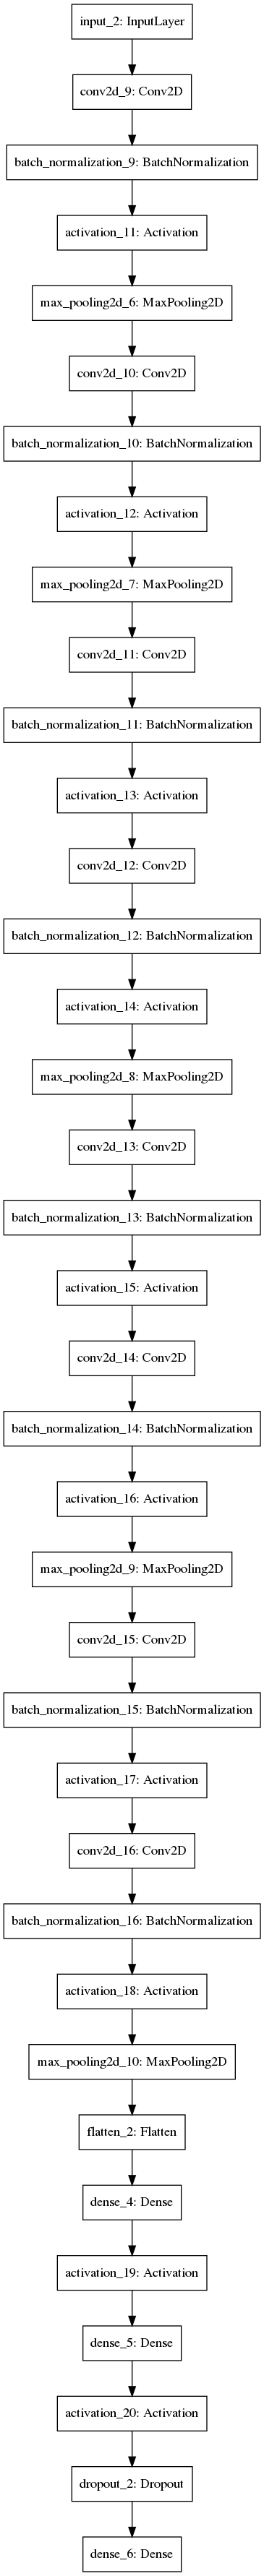

In [26]:
from keras.utils import plot_model
plot_model(net, to_file='model.png')